# 2019 NBA Hackathon - Business Analytics Track

Given a dataset of instagram posts from the @NBA instagram account, build a model that predicts the total number of enagements based on the contents of the post.

Accuracy Calculation: Mean Absolute Percentage Error

### Package Loadings

In [33]:
#importing all the libraries needed
import pandas as pd
import numpy as np
import datetime
from pytz import timezone
import random
from IPython.display import display
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from mlxtend.regressor import StackingCVRegressor
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_boston
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.externals import joblib
import os
import warnings
import re
%matplotlib inline

In [34]:
#Load Data
path = r'C:\Users\Spelk\Desktop\Georgia Tech Analytics\Stephen Data Science\Data Portfolio\2019 NBA Hackathon\Business Analytics'
os.chdir(path)

train = pd.read_csv("training_set.csv",encoding = "ISO-8859-1")
holdout = pd.read_csv("holdout_set.csv", encoding = "ISO-8859-1")

# Exploratory Data Analysis
Perform exploratory data analysis of the features in the dataset. Use the pre-defined features as well as custom features created from the 'Description' column.

### Team Mentions

In [35]:
#NBA Team mentions
nba_teams = ['hawks','celtics','nets','hornets','bucks','raptors','76ers','pacers','magic','pistons','heat','wizards','knicks',
            'bulls','cavaliers','warriors','nuggets','trailblazers','rockets','jazz','thunder','spurs','clippers','kings',
            'lakers','timberwolves','grizzlies','pelicans','mavericks','suns']


def first_team(row):
    for team in nba_teams:
        if str(team) in str(row):
            return team
    return "None"
train['First_Team_Mentioned'] = train['Description'].apply(lambda x:first_team(x))
train.head()

,Engagements,Followers at Posting,Created,Type,Description,First_Team_Mentioned
0,502093,36984682,2019-05-21 23:30:51 EDT,Video,The @raptors bench trio of @sergeibaka @norman...,raptors
1,603380,36984682,2019-05-21 22:53:33 EDT,Video,@kyle_lowry7 pulls from deep for the @raptors ...,raptors
2,603380,36984682,2019-05-21 22:19:58 EDT,Video,@k_mid22 with some english on the @bucks dime!,bucks
3,725100,36984682,2019-05-21 22:02:41 EDT,Video,Kawhi punches it home with the left on TNT!,None
4,661446,36984682,2019-05-21 20:47:49 EDT,Video,@giannis_an34 goes baseline early to rock the ...,None


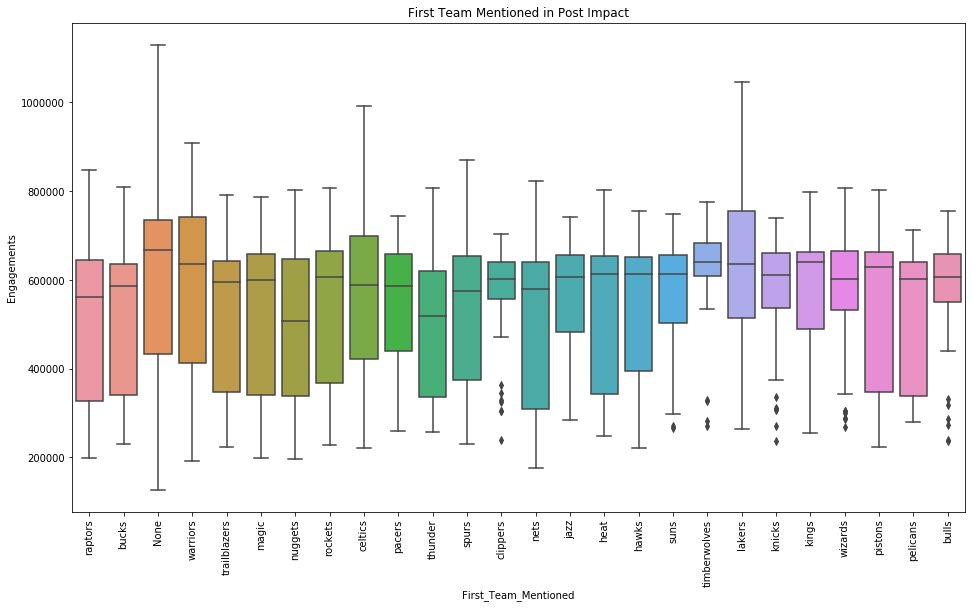

In [36]:
plt.rcParams["figure.figsize"] = (16,9)
sns.boxplot(x = train['First_Team_Mentioned'], y = train['Engagements']).set_title("First Team Mentioned in Post Impact")
plt.xticks(rotation = 'vertical')
plt.show()

### Description WordCloud
Look for the most common words included in the description of the post - exclude team names, as these will be in almost every post. Some player handles will show up in here as well - these could be predictive 

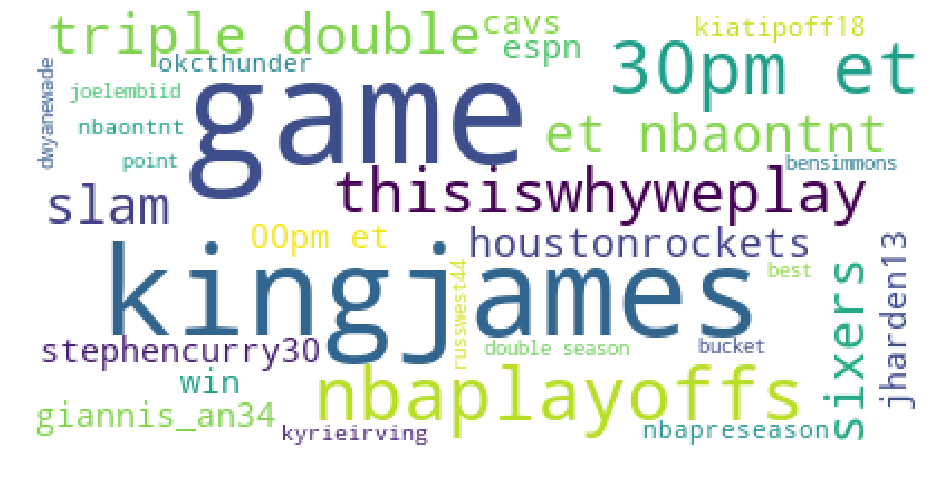

In [37]:
from wordcloud import WordCloud, STOPWORDS
#Word Cloud of Descriptions
word_list = train['Description'].tolist()
values = ' '.join(str(v).lower() for v in word_list)
stopwords = set(STOPWORDS)
for team in nba_teams:
    stopwords.add(team)

wordcloud = WordCloud(max_font_size=65, max_words=30,
                      background_color="white", stopwords = stopwords).generate(values)
plt.figure()
plt.rcParams["figure.figsize"] = (8,6)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Takeaways: Create indicators for "KingJames", "stephencurry30","giannis_an34", "nbaontnt", "NBAPlayoffs","ThisIsWhyWePlay","ESPN","SLAM"
- Possibly combine the players (LBJ, Steph, Giannis, and other stars) and the networks (TNT, ESPN)

Based on the wordcloud above, create some custom binary variables

In [38]:
#Create Indicators
train['Description'] = train['Description'].apply(lambda x: str(x).lower())
train['Lebron'] = train['Description'].apply(lambda x:'kingjames' in x)
train['Curry'] = train['Description'].apply(lambda x:'stephencurry30' in x)
train['Network'] = train['Description'].apply(lambda x:'espn' in x or 'nbaontnt' in x)
train['Playoffs'] = train['Description'].apply(lambda x:'nbaplayoffs' in x)
train['Punctuation'] = train['Description'].apply(lambda x:'!' in x or '?' in x)
train['WNBA'] = train['Description'].apply(lambda x:'wnba' in x)
train['Dunk'] = train['Description'].apply(lambda x:'dunk' in x or 'slam' in x)

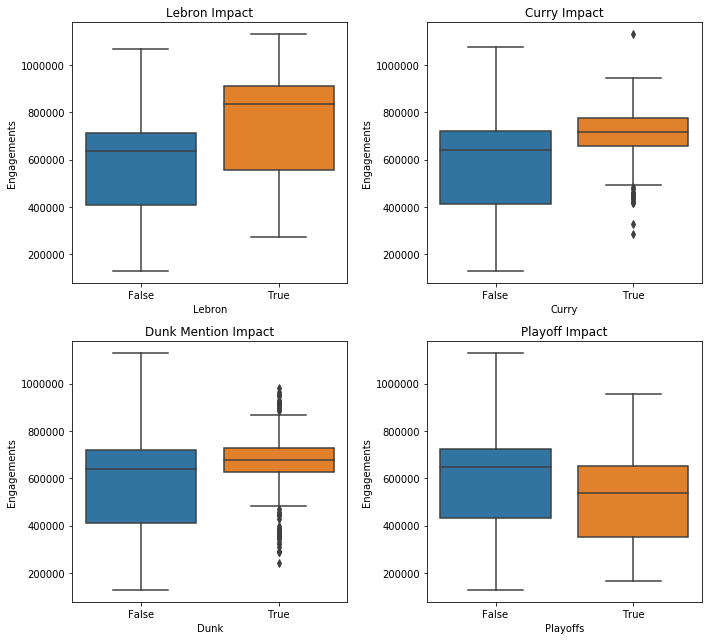

In [39]:
#Boxplots of Indicator Vars
plt.rcParams["figure.figsize"] = (10,9)
fig, ax =plt.subplots(2,2)
sns.boxplot(x = train['Lebron'], y = train['Engagements'], ax = ax[0,0]).set_title("Lebron Impact")
sns.boxplot(x = train['Curry'], y = train['Engagements'], ax = ax[0,1]).set_title("Curry Impact")
#sns.boxplot(x = train['Network'], y = train['Engagements'], ax = ax[1,0]).set_title("Network Mention Impact")
sns.boxplot(x = train['Dunk'], y = train['Engagements'], ax = ax[1,0]).set_title("Dunk Mention Impact")
sns.boxplot(x = train['Playoffs'], y = train['Engagements'], ax = ax[1,1]).set_title("Playoff Impact")
plt.tight_layout()
plt.show()

The variables showing differences in distribution are the Curry,LeBron, and Dunk/Slam indicators - it might be useful to create a "Stars" variable with the most popular NBA players in it

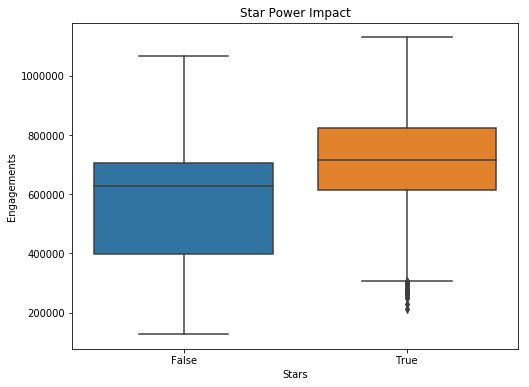

In [40]:
train['Stars'] = train['Description'].apply(lambda x:'stephencurry30' in str(x) or 'kingjames' in str(x)
                                           or 'giannis_an34' in str(x) or 'jharden13' in str(x) or 'easymoneysniper' in str(x))
plt.rcParams["figure.figsize"] = (8,6)
sns.boxplot(x = train['Stars'], y = train['Engagements']).set_title("Star Power Impact")
plt.show()

### Month and Day of Week
Do average engagements differ by the month and day they were posted?

C:\Users\Spelk\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1204: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
C:\Users\Spelk\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1204: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


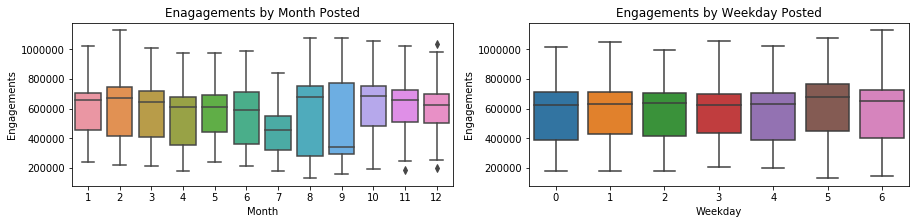

In [41]:
#Date Vars
train['Created'] = pd.to_datetime(train['Created'])
train['Weekday'] = train['Created'].apply(lambda x:str(datetime.datetime.weekday(x)))
train['Month'] = pd.DatetimeIndex(train['Created']).month
train['Hour'] = pd.DatetimeIndex(train['Created']).hour


#Boxplots of Month and Weekday
plt.rcParams["figure.figsize"] = (15,3)
fig, ax =plt.subplots(1,2)
sns.boxplot(x = train['Month'], y = train['Engagements'], ax = ax[0]).set_title("Enagagements by Month Posted")
sns.boxplot(x = train['Weekday'], y = train['Engagements'], ax = ax[1]).set_title("Engagements by Weekday Posted")
plt.show()

**Month:** month appears to have some impact on the number of enagagements (July is generally pretty low - could have July Indicator)

**Day** day of the week does not show any huge difference across days, except possibly some jump in engagements on the weekends (5-6)

### Hour of the Day

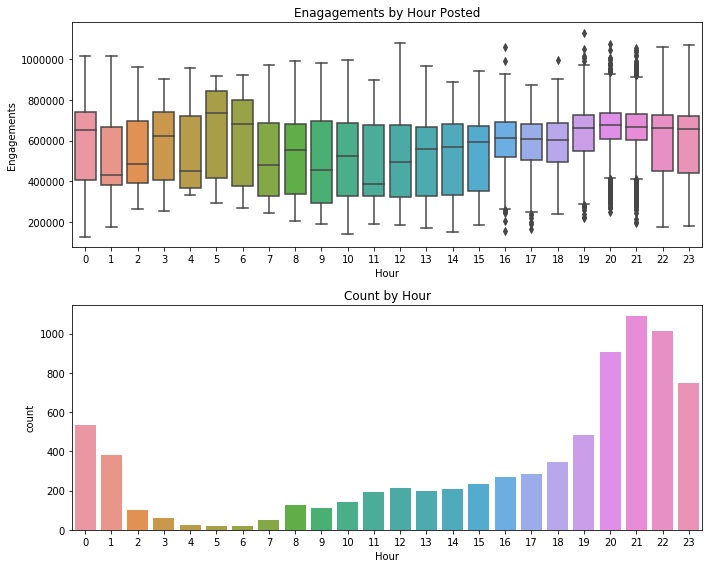

In [42]:
#Boxplots of Month and Weekday
plt.rcParams["figure.figsize"] = (10,8)
fig, ax =plt.subplots(2,1)
sns.boxplot(x = train['Hour'], y = train['Engagements'], ax = ax[0]).set_title("Enagagements by Hour Posted")
sns.countplot(x = train['Hour'], ax = ax[1]).set_title("Count by Hour")
plt.tight_layout()
plt.show()

**Hour:** The hour of the day posted seems to have a difference in the engagements - these could probably be grouped in bins/categories (0-4,5-10,etc.) or just use all of them
- significantly more posts happen during later hours

### Followers at Posting and Caption Length
- Also include 'Type' on the colors

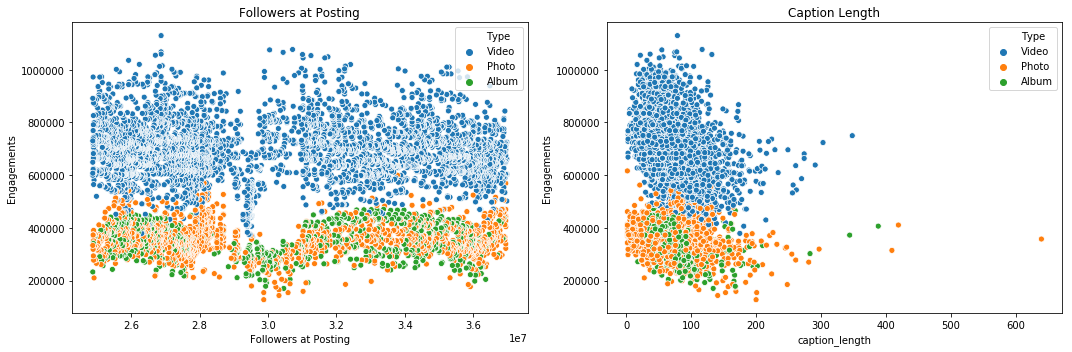

In [43]:
#Length of Caption
train['caption_length'] = train['Description'].apply(lambda row: len(str(row)))
plt.rcParams["figure.figsize"] = (15,5)
fig, ax =plt.subplots(1,2)
sns.scatterplot(x = train['Followers at Posting'], y = train['Engagements'],hue=train['Type'],
                ax=ax[0]).set_title("Followers at Posting")
sns.scatterplot(x = train['caption_length'], y = train['Engagements'],hue=train['Type'],
                ax=ax[1]).set_title("Caption Length")
plt.tight_layout()
plt.show()

**Followers at Posting:** Pretty consistent over time (assuming followers increase over time) - having more followers doesn't necessarily lead to more engagements. This is somewhat surprising.

**Caption Length:** Caption length doesn't show a strong correlation with engagements

**Type:** Videos clearly and consitently produce more engagements - this will likely be the most predictive feature

**See Tableau file for more interactive EDA**

### Engagement History and Overall Distribution

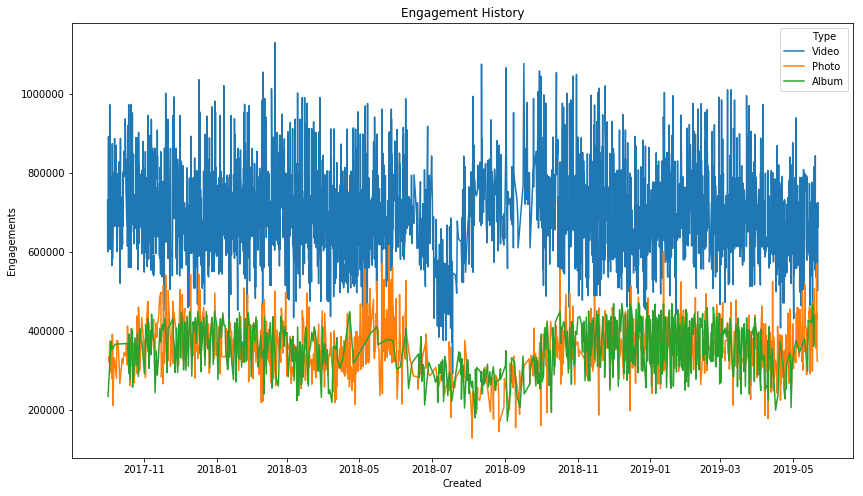

In [44]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.rcParams["figure.figsize"] = (14,8)
sns.lineplot(x = train['Created'], y = train['Engagements'], hue = train['Type']).set_title("Engagement History")
plt.show()

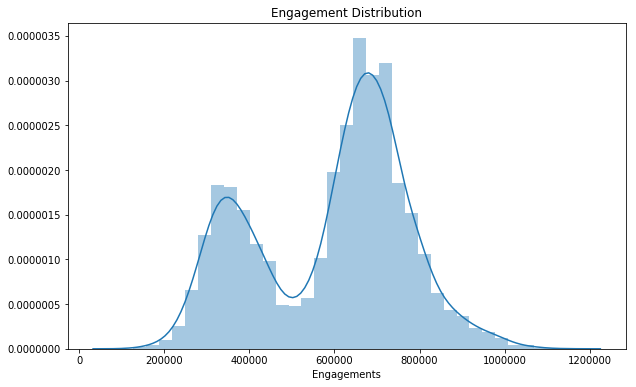

In [45]:
plt.rcParams["figure.figsize"] = (10,6)
sns.distplot(train['Engagements']).set_title("Engagement Distribution")
plt.show()

# Data Prep Function
- to be used on holdout set for all of the custom features created

In [48]:
#Function to be used on the holdout set with all necessary data prep
def data_prep(df):
    #Team
    df['First_Team_Mentioned'] = df['Description'].apply(lambda x:first_team(x))
    
    #Binary
    df['Description'] = df['Description'].apply(lambda x: str(x).lower())
    df['Lebron'] = df['Description'].apply(lambda x:'kingjames' in x)
    df['Curry'] = df['Description'].apply(lambda x:'stephencurry30' in x)
    df['Network'] = df['Description'].apply(lambda x:'espn' in x or 'nbaontnt' in x)
    df['Playoffs'] = df['Description'].apply(lambda x:'nbaplayoffs' in x)
    df['Punctuation'] = df['Description'].apply(lambda x:'!' in x or '?' in x)
    df['WNBA'] = df['Description'].apply(lambda x:'wnba' in x)
    df['Dunk'] = df['Description'].apply(lambda x:'dunk' in x or 'slam' in x)
    df['Stars'] = df['Description'].apply(lambda x:'stephencurry30' in str(x) or 'kingjames' in str(x)
                                           or 'giannis_an34' in str(x) or 'jharden13' in str(x) or 'easymoneysniper' in str(x))
    
    #Date Vars
    df['Created'] = pd.to_datetime(df['Created'])
    df['Weekday'] = df['Created'].apply(lambda x:str(datetime.datetime.weekday(x)))
    df['Month'] = pd.DatetimeIndex(df['Created']).month
    df['Hour'] = pd.DatetimeIndex(df['Created']).hour
    
    #Change hour and month to strings
    df['Hour'] = df['Hour'].apply(lambda x: str(x))
    df['Month'] = df['Month'].apply(lambda x: str(x))

    #Length of Caption
    df['caption_length'] = df['Description'].apply(lambda row: len(str(row)))

    #Drop variables and create dummies
    df = df.drop(['Created','Description','Engagements'], axis = 1)
    df2 = pd.get_dummies(df)
    return df2

holdout2= data_prep(holdout)

In [49]:
#Change hour and month to strings
train['Hour'] = train['Hour'].apply(lambda x: str(x))
train['Month'] = train['Month'].apply(lambda x: str(x))

#Export preds for Tableau EDA
train.to_csv("preds.csv", index = False)

#Create dummy vars
train = train.drop(['Created','Description'], axis = 1)
train2 = pd.get_dummies(train)

In [50]:
#Split data into train and test sets
random.seed(20)
train, test = train_test_split(train2, test_size = 0.3)

In [51]:
#Define Predictors and Response Variable
y_train = train.iloc[ :,0]
x_train = train.iloc[:,1:]
y_test = test.iloc[ :,0]
x_test = test.iloc[:,1:]

# Baseline Model - Linear Regression
- use for comparison to more complex models
- how much do we gain from using a harder-to-understand model?

In [53]:
lr = LinearRegression()
lr.fit(x_train,y_train)

# Predict on Test Set
predictions = lr.predict(x_test)
errors = abs(predictions - y_test)
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Baseline Accuracy:', round(accuracy, 2), '%.')

Baseline Accuracy: 91.3 %.


# Random Forest Model

In [54]:
#RF model
rf = RandomForestRegressor(n_estimators = 800, random_state = 24)
# Train the model on training data
rf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=None,
           oob_score=False, random_state=24, verbose=0, warm_start=False)

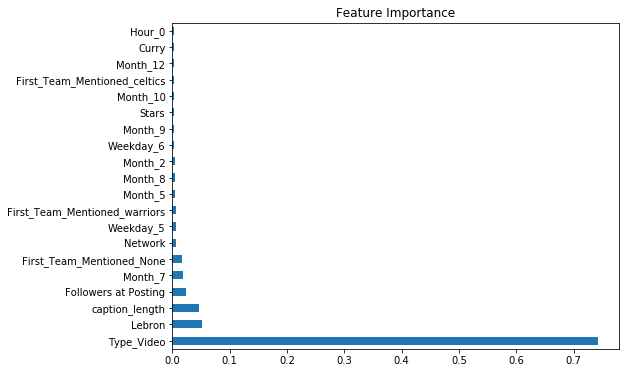

In [55]:
#Feature Importance
plt.rcParams["figure.figsize"] = (8,6)
feat_importances = pd.Series(rf.feature_importances_, index=x_train.columns)
feat_importances.nlargest(20).plot(kind='barh').set_title("Feature Importance")
plt.show()

In [56]:
# Predict on Test Set
predictions = rf.predict(x_test)
errors = abs(predictions - y_test)
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 92.79 %.


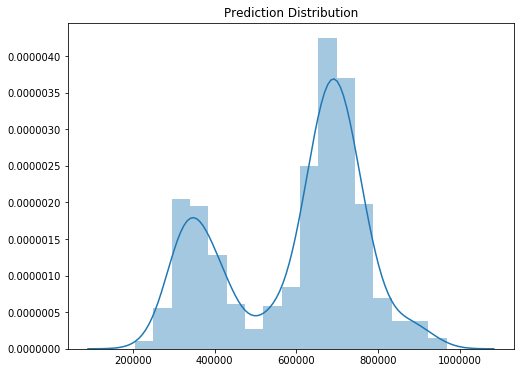

In [57]:
sns.distplot(predictions).set_title("Prediction Distribution")
plt.show()

### Warning: the cell below will run for 5-10 minutes
- commented out becasue the model was not used

In [25]:
'''#Grid Search Random Forest
param_grid = {
    'bootstrap': [True],
    'max_depth': [8, 10, 12,13,14,15,16,17],
    'n_estimators': [500,700,800,900,1000]}

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 2, n_jobs = -1, verbose = 2)

grid_search.fit(x_train, y_train)
best_grid = grid_search.best_estimator_

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
grid_accuracy = evaluate(best_grid, x_test, y_test)

plt.rcParams["figure.figsize"] = (8,6)
r = sns.regplot(x = y_test, y = predictions, color = 'g').set_title("Test Set Engagements vs Predictions")
plt.show()'''

'#Grid Search Random Forest\nparam_grid = {\n    \'bootstrap\': [True],\n    \'max_depth\': [8, 10, 12,13,14,15,16,17],\n    \'n_estimators\': [500,700,800,900,1000]}\n\ngrid_search = GridSearchCV(estimator = rf, param_grid = param_grid, \n                          cv = 2, n_jobs = -1, verbose = 2)\n\ngrid_search.fit(x_train, y_train)\nbest_grid = grid_search.best_estimator_\n\ndef evaluate(model, test_features, test_labels):\n    predictions = model.predict(test_features)\n    errors = abs(predictions - test_labels)\n    mape = 100 * np.mean(errors / test_labels)\n    accuracy = 100 - mape\n    print(\'Model Performance\')\n    print(\'Average Error: {:0.4f} degrees.\'.format(np.mean(errors)))\n    print(\'Accuracy = {:0.2f}%.\'.format(accuracy))\n    \n    return accuracy\ngrid_accuracy = evaluate(best_grid, x_test, y_test)\n\nplt.rcParams["figure.figsize"] = (8,6)\nr = sns.regplot(x = y_test, y = predictions, color = \'g\').set_title("Test Set Engagements vs Predictions")\nplt.show(

# XGBoost Model

In [58]:
X = train2.iloc[:,1:]
Y = train2['Engagements']
matrix = xgb.DMatrix(data=X,label=Y)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=12)

In [59]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.01,
                max_depth = 5, alpha = 10, n_estimators = 500)

xg_reg.fit(X_train,y_train)

#Predictions and Accuracy
preds = xg_reg.predict(X_test)
errors = abs(preds - y_test)
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 91.96 %.


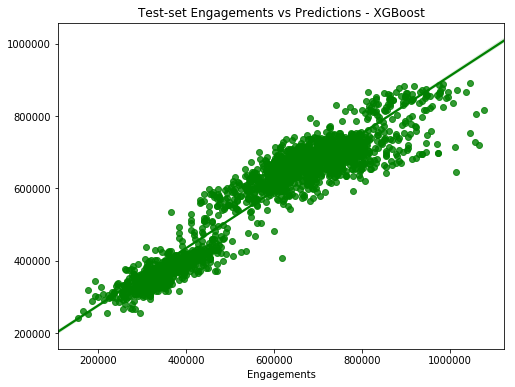

In [60]:
plt.rcParams["figure.figsize"] = (8,6)
r = sns.regplot(x = y_test, y = preds, color = 'g').set_title("Test-set Engagements vs Predictions - XGBoost")
plt.show()

# Results

The first Random Forest created was the best model in terms of having the lowest MAPE. This is the model that will be used to make predictions on the holdout set.

In [61]:
# Predict on Holdout Set
predictions = rf.predict(holdout2)

In [66]:
holdout['Engagements'] = predictions
holdout = holdout[['Engagements','Followers at Posting','Created','Type','Description']]
holdout.head()

,Engagements,Followers at Posting,Created,Type,Description
0,362193.63125,36984682,2019-05-22 00:31:55,Photo,the @raptors even up the eastern conference fi...
1,300442.77625,36984682,2019-05-21 23:20:41,Photo,the @raptors even the eastern conference final...
2,630561.25125,36984682,2019-05-21 21:18:51,Video,@sergeibaka keeps it alive for the @raptors! (...
3,557044.32000,36955156,2019-05-21 18:20:09,Video,???? the superhuman hands of giannis & kawhi ?...
4,538332.23000,36955156,2019-05-21 15:04:31,Video,?? the @raptors & @bucks in transition! #nbabr...


In [67]:
#Export for submission
holdout.to_csv("holdout_set_[SP24_JP33].csv",index=False)